In [1]:
# Create a requirements.txt file
%%writefile requirements.txt
transformers
datasets
matplotlib
umap-learn
accelerate

Writing requirements.txt


In [2]:
# Install the reqs file
!pip install -qr requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [3]:
from datasets import load_dataset, DatasetDict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch
import numpy as np
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, accuracy_score
from transformers import Trainer, TrainingArguments
from huggingface_hub import notebook_login
from sklearn.model_selection import train_test_split

In [4]:
# Load the dataset ('emotions')
emotions = load_dataset('emotone_ar')
emotions

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/10065 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label'],
        num_rows: 10065
    })
})

In [6]:
emotions_train_test = emotions["train"].train_test_split(test_size=0.2, seed=42)
emotions_test_valid = emotions_train_test["test"].train_test_split(test_size=0.5, seed=42)

emotions = DatasetDict({
    'train': emotions_train_test['train'],
    'test': emotions_test_valid['train'],
    'validation': emotions_test_valid['test']
})
emotions

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label'],
        num_rows: 8052
    })
    test: Dataset({
        features: ['tweet', 'label'],
        num_rows: 1006
    })
    validation: Dataset({
        features: ['tweet', 'label'],
        num_rows: 1007
    })
})

In [7]:
# Let's examine the dataset
train_ds = emotions['train']
train_ds

Dataset({
    features: ['tweet', 'label'],
    num_rows: 8052
})

In [8]:
# Check smaple of the rows in traning dataset
train_ds[0:5]

{'tweet': ['الله يفرج همهم، ادعيلنا نيب اسيا 💜',
  'خايف اتعـود علي الدنيا بدونك ، هذا اغـرب خوف مـر بـحياتي !',
  'q8 88: كَلِمهٌ مِنْكْ . . . اخَذَتْني الَي عَالَمٍ اخَر لَمْ اسْتَطِع بَعْدَها سَماعَ باقـي الكَلِماتْ ♥  عشششششق',
  'انا كل 5 دقايق بسمه خبر خروج مصري من الاوليمبياد الامل في منتخب اليد بقا',
  '34: كثيره هي اللحظات التي اعيشها بين الناس   سهيل  نبوءه العشق  ملتقي الاقلام  طلاسم الحب  فجر للتبادل  الملوك للتبادل'],
 'label': [5, 7, 4, 0, 3]}

In [9]:
# Check the datatypes and class names
train_ds.features

{'tweet': Value(dtype='string', id=None),
 'label': ClassLabel(names=['none', 'anger', 'joy', 'sadness', 'love', 'sympathy', 'surprise', 'fear'], id=None)}

In [10]:
# Let's convert it to pandas for easy working
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,tweet,label
0,الله يفرج همهم، ادعيلنا نيب اسيا 💜,5
1,خايف اتعـود علي الدنيا بدونك ، هذا اغـرب خوف م...,7
2,q8 88: كَلِمهٌ مِنْكْ . . . اخَذَتْني الَي عَا...,4
3,انا كل 5 دقايق بسمه خبر خروج مصري من الاوليمبي...,0
4,34: كثيره هي اللحظات التي اعيشها بين الناس س...,3


In [11]:
# Because the labels are represented in integers. I will create a function to map the integers to strings
def label_int2str(row):
  return emotions['train'].features['label'].int2str(row)

# Apply above function to the label column in the DF
df['label_name'] = df['label'].apply(label_int2str)

# Check again
df.head()

,tweet,label,label_name
0,الله يفرج همهم، ادعيلنا نيب اسيا 💜,5,sympathy
1,خايف اتعـود علي الدنيا بدونك ، هذا اغـرب خوف م...,7,fear
2,q8 88: كَلِمهٌ مِنْكْ . . . اخَذَتْني الَي عَا...,4,love
3,انا كل 5 دقايق بسمه خبر خروج مصري من الاوليمبي...,0,none
4,34: كثيره هي اللحظات التي اعيشها بين الناس س...,3,sadness


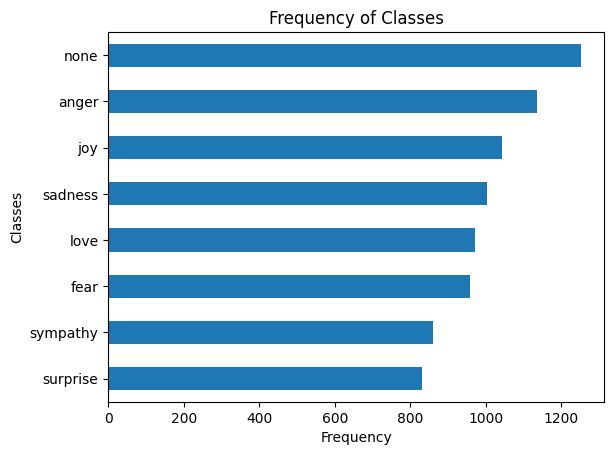

In [12]:
# Let's exmaine the class distribution
df['label_name'].value_counts(ascending=True).plot(kind='barh')
plt.title('Frequency of Classes', fontsize=12, c='k')
plt.ylabel('Classes')
plt.xlabel('Frequency')
plt.show()

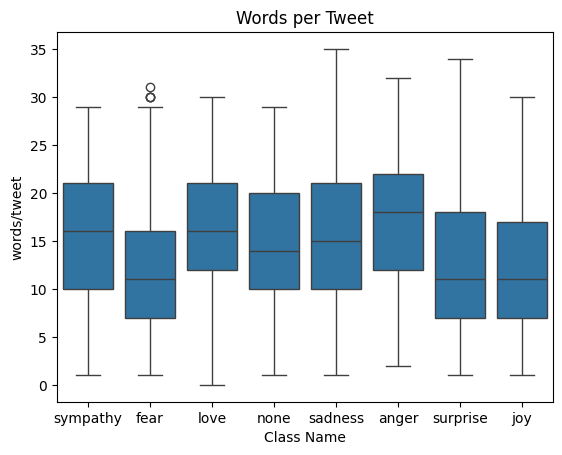

In [13]:
# Check the distribution of tweets length per each class
df['words/tweet'] = df['tweet'].str.split().apply(len)

# Plotting
sns.boxplot(data=df, y='words/tweet', x='label_name')
plt.title('Words per Tweet', fontsize=12, c='k')
plt.xlabel('Class Name')
plt.ylabel('words/tweet')
plt.show()

In [14]:
# Reset Format from pandas to nested dictionary
emotions.reset_format()

### `Data Preprocessing`

In [15]:
# Get the model checkPoint and load the tokenizer
model_ckpt = 'distilbert/distilbert-base-multilingual-cased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

In [16]:
# Let's examine the tokenizer
text = 'يجب ان تكون رحيما'
encoded_text = tokenizer(text, return_tensors='pt')
print(encoded_text )

{'input_ids': tensor([[  101, 44511, 14269, 24027,   773, 40926, 14495,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}


In [17]:
# To get the tokens itself
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids[0], skip_special_tokens=False)
print(tokens)

['[CLS]', 'يجب', 'ان', 'تكون', 'ر', '##حي', '##ما', '[SEP]']


In [18]:
# To return back to the original text
regen_text = tokenizer.convert_tokens_to_string(tokens)
print(regen_text)

[CLS] يجب ان تكون رحيما [SEP]


In [19]:
# We can check the vocab. size and the max-length of context window
print(f'The vocab size of DistillBert Model is: {tokenizer.vocab_size}')
print(f'The context window of DistillBert Model is: {tokenizer.model_max_length}')

The vocab size of DistillBert Model is: 119547
The context window of DistillBert Model is: 512


In [20]:
# Ok. Let's tokenize the whole dataset
def tokenize_fn(batch):
  ## Padding the short sentences and truncate the long sentences
  return tokenizer(batch['tweet'], padding=True, truncation=True, max_length=512, return_tensors='pt')

# Examine the function (for the first two examples in the dataset)
tokenize_fn(emotions['train'][0:2])

{'input_ids': tensor([[   101,  15764,    793,  24455,  13027,  39468,  10700,    752,    763,
          10658,  32160,  66803,  10429,    789,  26917,  11722,  14431,    100,
            102,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0],
        [   101,    770,  67261,  11687,    763,  10502,  11693, 105563,  16351,
          19163,  59901,  22955,  14431,  32220,  12497,    752,  13498,    763,
          17329, 105563,  30075,    770,  22468,    788, 105563,  10673,  20496,
          40926, 104061,    106,    102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1]])}

In [21]:
# Apply the above function of tokenization to the whole dataset
emotions_encoded = emotions.map(tokenize_fn, batched=True, batch_size=None)

# I dont specify the batch_size to apply to the whole dataset as a single batch. to make the input_ids and attention_mask of the same shape globally

# Check after tokenizing
emotions_encoded['train'].column_names

Map:   0%|          | 0/8052 [00:00<?, ? examples/s]

Map:   0%|          | 0/1006 [00:00<?, ? examples/s]

Map:   0%|          | 0/1007 [00:00<?, ? examples/s]

['tweet', 'label', 'input_ids', 'attention_mask']

### `Training a Text Classifier`

In [22]:
# check CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'The device is: {device}')

The device is: cuda


In [23]:
# Load the DistillBert model from its checkpoint
model = AutoModel.from_pretrained(model_ckpt).to(device)

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

* `Try on Test Example`

In [24]:
# Extracting the last hidden states
text = 'هذه تجربة'
inputs_test = tokenizer(text, return_tensors='pt')
tokens_test = tokenizer.convert_ids_to_tokens(inputs_test.input_ids[0], skip_special_tokens=False)

print('Tokens:')
print(tokens_test)
print()
print(f'Input tensor shape {inputs_test["input_ids"].size()}') # Has the shape of [batch_size x n_tokens]

Tokens:
['[CLS]', 'هذه', 'ت', '##جر', '##بة', '[SEP]']

Input tensor shape torch.Size([1, 6])


In [25]:
# Pass tensors to GPU
inputs_test = {k: v.to(device) for k, v in inputs_test.items()}


# Get the model hidden states
# Using this context manager to disable calculation of the gradient
with torch.no_grad():
  outputs_test = model(**inputs_test)

print(outputs_test)

BaseModelOutput(last_hidden_state=tensor([[[-3.1620e-02, -7.1842e-02,  5.6872e-01,  ...,  2.1492e-03,
           9.2657e-02, -1.3430e-01],
         [-1.4289e-02, -3.8059e-01,  1.3370e+00,  ..., -2.0478e-04,
           3.0479e-01,  3.9457e-02],
         [-1.5794e-01, -4.5034e-01,  1.0449e+00,  ..., -2.0020e-02,
           1.4894e-01, -1.1076e-01],
         [-5.6971e-01, -2.4775e-01,  1.4174e+00,  ..., -4.4927e-02,
           6.0045e-01, -1.7526e-01],
         [-2.2477e-01, -2.6093e-01,  1.8044e+00,  ...,  5.3359e-02,
          -1.6491e-02, -3.5348e-01],
         [ 6.0244e-02, -2.6044e-01,  1.2011e+00,  ..., -1.7392e-01,
           5.5356e-02, -8.6988e-02]]], device='cuda:0'), hidden_states=None, attentions=None)


In [26]:
# Let's look at the shape of the hidden state tensor
outputs_test.last_hidden_state.size()  # Has shape of [batch_size x n_tokens x hidden_dim].

# it means that a 768-dimensional vector is returned for each of 6 tokens in my test example

torch.Size([1, 6, 768])

In [27]:
# It is common practice to use just the hidden state of the [CLS] token.
outputs_test.last_hidden_state[:, 0, :].size()  # taking the first token only [CLS] for classification

torch.Size([1, 768])

* `Apply on my dataset`

In [28]:
# Let's combine that in function
def extract_hidden_states_fn(batch):

  # Place the model input to the GPU
  inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

  # Extract the last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state

  ## Get only the vector of the first token [CLS], and convert back to cpu and numpy
  return {'hidden_state': last_hidden_state[:, 0, :].cpu().numpy()}

# Convert the tokenized numerical data (input_ids, attention_mask, label) to tensors
# I already tokenize the dataset, so I dont even need the text column
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Apply the above function using the magic function (map) on the tokenized data
emotions_hidden = emotions_encoded.map(extract_hidden_states_fn, batched=True, batch_size=1000)
emotions_hidden

Map:   0%|          | 0/8052 [00:00<?, ? examples/s]

Map:   0%|          | 0/1006 [00:00<?, ? examples/s]

Map:   0%|          | 0/1007 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 8052
    })
    test: Dataset({
        features: ['tweet', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 1006
    })
    validation: Dataset({
        features: ['tweet', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 1007
    })
})

In [29]:
# Applying the above function has added a new column
emotions_hidden['train'].column_names

['tweet', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [30]:
emotions_hidden

DatasetDict({
    train: Dataset({
        features: ['tweet', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 8052
    })
    test: Dataset({
        features: ['tweet', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 1006
    })
    validation: Dataset({
        features: ['tweet', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 1007
    })
})

In [31]:
# Creating the feature matrix and the target
X = np.array(emotions_hidden['train']['hidden_state'])
y = np.array(emotions_hidden['train']['label'])

In [32]:
# Creating the feature matrix and the target (Train, Valid, and Test)

# Features
X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
X_test = np.array(emotions_hidden['test']['hidden_state'])

# Target
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])
y_test = np.array(emotions_hidden['test']['label'])


# Check the shapes
print('X_train.shape -->', X_train.shape)
print('y_train', y_train.shape)
print('---'*10)
print('X_valid.shape -->', X_valid.shape)
print('y_valid.shape -->', y_valid.shape)
print('---'*10)
print('X_test.shape -->', X_test.shape)
print('y_test.shape -->', y_test.shape)

X_train.shape --> (8052, 768)
y_train (8052,)
------------------------------
X_valid.shape --> (1007, 768)
y_valid.shape --> (1007,)
------------------------------
X_test.shape --> (1006, 768)
y_test.shape --> (1006,)


#### `Vizualization in 2D`

In [33]:
##Scaling the X_train features between [0, 1]
X_scaled = MinMaxScaler().fit_transform(X_train)

# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
# Create a DF of 2D embeddings
df_embed = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])

# Add the label to make hue using it
df_embed['label'] = y_train

# Finally, Check
df_embed.head()

,X,Y,label
0,7.683431,-0.915938,5
1,-0.101267,10.827234,7
2,9.219955,3.167576,4
3,13.951765,7.577074,0
4,12.255463,5.613655,3


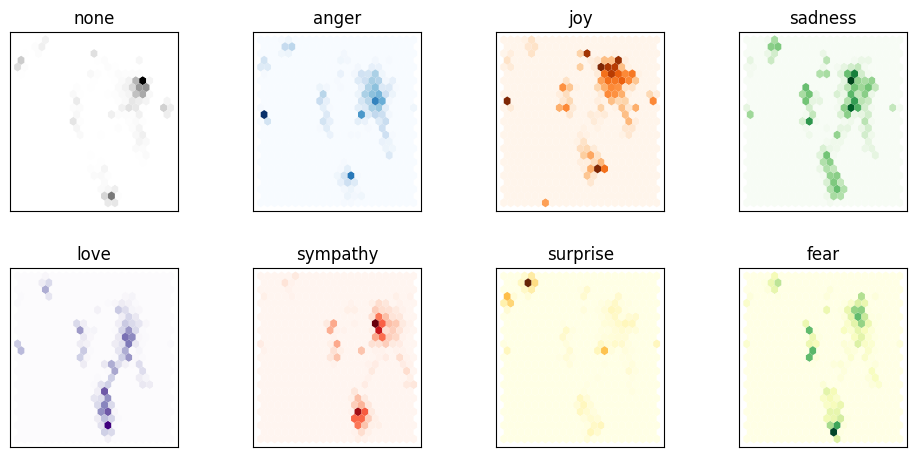

In [34]:
# Plotting (I have 6 classes)
fig, ax = plt.subplots(2, 4, figsize=(10, 5))
fig.tight_layout(pad=2)
ax = ax.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Greens', 'Purples', 'Reds', 'YlOrBr', 'YlGn']
labels = emotions['train'].features['label'].names

# Plotting using Hexagonal Binning
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_embed_sub = df_embed.query(f'label== {i}')
  ax[i].hexbin(df_embed_sub['X'], df_embed_sub['Y'], cmap=cmap, gridsize=22, linewidth=(0,))
  ax[i].set_title(label)
  ax[i].set_xticks([])  # make no values on x axis
  ax[i].set_yticks([])  # make no value on y axis

plt.show()

### `Training a BaseLine Classifier`

In [35]:
# Let's create a function for plotting the confusion matrix
labels = emotions['train'].features['label'].names

def plot_conf_matrix_fn(y_preds, y_true):
  conf_mat = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(6, 6))

  conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
  conf_mat_disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
  plt.title('Normalized confusion Matrix', fontsize=12, c='k')
  plt.show()

Accuracy score using LogisiticRegression 0.556


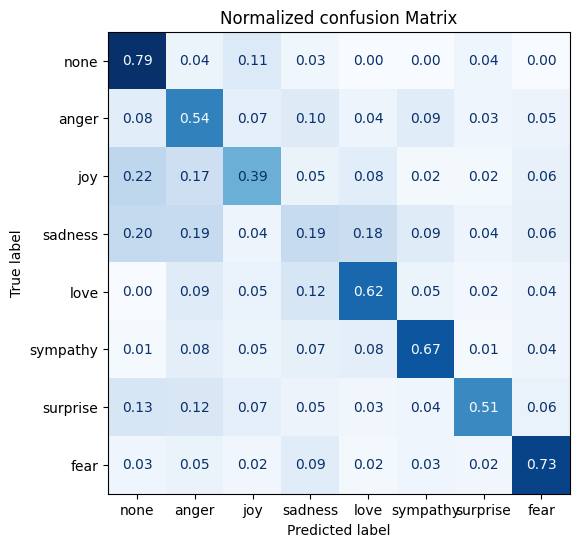

In [36]:
# Using Logistic Regression
log_clf = LogisticRegression(max_iter=3000)
log_clf.fit(X_train, y_train)

# Get the accuracy score
score_log = log_clf.score(X_valid, y_valid)
print(f'Accuracy score using LogisiticRegression {score_log:.3f}')

# Get the prediction onn valid dataset, and call the above function to draw the conf matrix
y_preds_log = log_clf.predict(X_valid)

# Call the function for plotting confusion matrix
plot_conf_matrix_fn(y_preds=y_preds_log, y_true=y_valid)

### `Fine-Tuning DistillBERT`

In [37]:
# Login using Key Token from HuggingFace (to be write permission)
notebook_login()

In [38]:
# Load the model with random weights of head classifier
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=8).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
# Define the performance metrics (I will use accuracy and f1_score)
def compute_metrics_fn(pred):
  labels = pred.label_ids  # The Ground Truth
  preds = pred.predictions.argmax(-1)   # The predictions

  # Calculate the f1 & accuracy
  f1 = f1_score(labels, preds, average='weighted')  # It is multiclass
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'f1': f1}

In [44]:
# Prepare the training arguments
batch_size = 32
logging_steps = len(emotions_encoded['train']) // batch_size

# a checkpoint name
my_model_chkpt = f'{model_ckpt}-finetuned'

# Define some training arguments
training_args = TrainingArguments(output_dir=my_model_chkpt,
                                  num_train_epochs=10,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level='info')

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [45]:
# Initialize the Trainer API
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics_fn,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer)

# Start Training
trainer.train();

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet. If tweet are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 8,052
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 2,520
  Number of trainable parameters = 135,330,824


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.472500,1.089168,0.660377,0.662542
2,0.339200,1.209617,0.659384,0.664853
3,0.257500,1.274470,0.672294,0.670634
4,0.197900,1.371929,0.671301,0.666644
5,0.175700,1.423906,0.672294,0.665243
6,0.141400,1.507410,0.666336,0.666580
7,0.107300,1.570286,0.678252,0.672215
8,0.081200,1.621811,0.667329,0.663773
9,0.061500,1.667624,0.669315,0.664189
10,0.053100,1.674044,0.664350,0.661104


The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet. If tweet are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 1007
  Batch size = 32
Saving model checkpoint to distilbert/distilbert-base-multilingual-cased-finetuned/checkpoint-500
Configuration saved in distilbert/distilbert-base-multilingual-cased-finetuned/checkpoint-500/config.json
Model weights saved in distilbert/distilbert-base-multilingual-cased-finetuned/checkpoint-500/model.safetensors
tokenizer config file saved in distilbert/distilbert-base-multilingual-cased-finetuned/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert/distilbert-base-multilingual-cased-finetuned/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert/distilbert-base-multilingual-cased-finetuned/token

In [46]:
# Examine the performance of the model on the validation dataset
preds_output_valid = trainer.predict(emotions_encoded['validation'])
preds_output_valid

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: tweet. If tweet are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 1007
  Batch size = 32


PredictionOutput(predictions=array([[ 3.3409698 , -2.208519  , -1.1696254 , ..., -4.1798925 ,
        -0.16396414, -2.4064107 ],
       [ 2.5808814 ,  2.5912118 , -4.0110435 , ..., -2.942317  ,
         2.8105745 , -1.8384429 ],
       [-3.3985682 , -2.2306538 , -1.3483078 , ..., -1.095473  ,
        -2.5482433 , -1.209823  ],
       ...,
       [ 6.8556156 , -2.1405365 ,  0.37221158, ..., -3.7080278 ,
        -1.1717075 , -1.7866303 ],
       [-1.3024536 , -1.5190973 , -1.7416968 , ...,  7.5219646 ,
        -1.8104416 , -1.1066513 ],
       [-2.839913  , -1.8216915 , -1.61759   , ..., -1.9544016 ,
        -1.9781651 ,  8.009434  ]], dtype=float32), label_ids=array([0, 1, 3, ..., 0, 5, 7]), metrics={'test_loss': 1.6740436553955078, 'test_accuracy': 0.6643495531281033, 'test_f1': 0.6611042747196898, 'test_runtime': 2.4083, 'test_samples_per_second': 418.14, 'test_steps_per_second': 13.287})

In [47]:
# Get the metrics for the validation dataset
preds_output_valid.metrics

{'test_loss': 1.6740436553955078,
 'test_accuracy': 0.6643495531281033,
 'test_f1': 0.6611042747196898,
 'test_runtime': 2.4083,
 'test_samples_per_second': 418.14,
 'test_steps_per_second': 13.287}

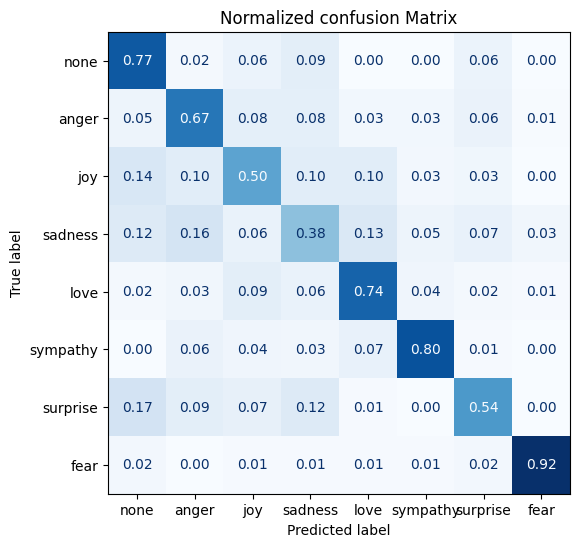

In [48]:
# Get the y_predictions
y_preds_valid = np.argmax(preds_output_valid.predictions, axis=1)

# Plotting the confusion matrix --> Calling the above function
plot_conf_matrix_fn(y_preds=y_preds_valid, y_true=y_valid)

### `Error Analysis`

In [49]:
from torch.nn.functional import cross_entropy

In [50]:
# Let's investigate the models's predictions much more
# What about sorting the validation samples by the model loss (cross entropy)


def forward_pass_label_and_loss(batch):

  # Pass the tensors to device like we did to the model
  inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

  # inference with no gradients calculations
  with torch.no_grad():
    outputs = model(**inputs)  # Model here is my fine-tuned model with the classifier head
    pred_label = torch.argmax(outputs.logits, axis=-1)  # Getting the class index that has the top logit (max score)
    loss = cross_entropy(input=outputs.logits, target=batch['label'].to(device), reduction='none')
    return {'loss': loss.cpu().numpy(), 'predicted_label': pred_label.cpu().numpy()}


# Using the magic function (map) and apply thr above function on validation dataset
emotions_encoded['validation'] = emotions_encoded['validation'].map(forward_pass_label_and_loss, batched=True, batch_size=16)

# Check again: Created two new cols as expected (loss & predicted_label)
emotions_encoded['validation']

Map:   0%|          | 0/1007 [00:00<?, ? examples/s]

Dataset({
    features: ['tweet', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label'],
    num_rows: 1007
})

In [52]:
# Convert to pandas
emotions_encoded.set_format('pandas')
cols = ['tweet', 'label', 'predicted_label', 'loss']

# Slicing the cols from the validation dataset only to work on them
df_valid_sample = emotions_encoded['validation'][:][cols]

# Convert the label & predicted_label cols to string
df_valid_sample['label'] = df_valid_sample['label'].apply(label_int2str)
df_valid_sample['predicted_label'] = df_valid_sample['predicted_label'].apply(label_int2str)

# Sort descending by loss
df_valid_sample.sort_values(by='loss', ascending=False, inplace=True)

# Check head the DF (the loss is high at the start of DF)
df_valid_sample.head(10)

,tweet,label,predicted_label,loss
88,و هيا توصيني ان امسكها من يدها كٍ لا اضيع وهيا...,love,anger,9.925732
740,مدري ليش السخريه من اصحاب اللحي والملتزمين وكا...,sympathy,anger,9.837428
172,: مضايا تموت جوعاً لكن قواتنا بالتحالف تركز ع...,sympathy,anger,9.500818
958,: حسبنا الله ونعم الوكيل. ملحمه حلب الكبري ...,anger,sympathy,9.453486
798,احبابنا اني اغالب حسرهً مشبوبهً وعلي الاسي اتج...,sympathy,love,9.447155
76,: القرضاوي: الله افشل الانقلاب القذر في تركيا,none,anger,9.300711
562,al9dee8: يارب بشره بما لا عين رات ولا اذن سمعت...,joy,sympathy,9.172984
50,اختي في لاتلطمي ولاتصيحي,sympathy,joy,9.145383
86,: احدهم يقتل والداه قربانا للبغدادي واخريقتل ر...,sympathy,anger,9.011455
243,فاتت سنه.. مياده الحناوي ياشيخه يخربيت الفجر ا...,surprise,anger,8.937365


In [57]:
df_valid_sample.iloc[1]['tweet']

'مدري ليش السخريه من اصحاب اللحي والملتزمين وكانهم ليسوا منا وكانهم كائنات فضائيه غريبه عنا!هم ليسوا واحدا اونسخه واحده  لا تتزوجي مطوع'

> `There are some incorrect labelling of some instances in the dataset, That may causes errors in fine-tuned model`

In [53]:
# Check the tail DF (the loss is low at the end of DF)
df_valid_sample.tail(10)

,tweet,label,predicted_label,loss
483,خايفه اقوله عن شعوري واخسره 😩❤️,fear,fear,0.000392
101,ميته نوم و خايفه اطلع لغرفتي لان ابوي مسافر وم...,fear,fear,0.000388
226,خايفه انوض ماما تزرطني معاها في الغداء,fear,fear,0.000386
540,انا خايفه عليكي,fear,fear,0.000382
406,خايفه امسِك ف ايدك، ترجَعني تاني للوجّع ..,fear,fear,0.000381
759,01 خايفه عليكم,fear,fear,0.000378
650,خايفه اكل 😐,fear,fear,0.000376
184,خايفه وبقوه كمان بس السبب مجهول .,fear,fear,0.000373
790,خايفه اموت ومتعرفش 💔,fear,fear,0.000368
930,لا جد خايفه اغرد واتفشل😂😂😂,fear,fear,0.000364


In [58]:
# Finally, Saving and sharing model
trainer.push_to_hub(commit_message='Training Complete')

Saving model checkpoint to distilbert/distilbert-base-multilingual-cased-finetuned
Configuration saved in distilbert/distilbert-base-multilingual-cased-finetuned/config.json
Model weights saved in distilbert/distilbert-base-multilingual-cased-finetuned/model.safetensors
tokenizer config file saved in distilbert/distilbert-base-multilingual-cased-finetuned/tokenizer_config.json
Special tokens file saved in distilbert/distilbert-base-multilingual-cased-finetuned/special_tokens_map.json
Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.6643495531281033}, {'name': 'F1', 'type': 'f1', 'value': 0.6611042747196898}]}


model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1724758266.8d1e8f5deb25.179.2:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Esmail275/distilbert-base-multilingual-cased-finetuned/commit/5777ca12bed7e382fab99392beced1f3e4bc7ea1', commit_message='Training Complete', commit_description='', oid='5777ca12bed7e382fab99392beced1f3e4bc7ea1', pr_url=None, pr_revision=None, pr_num=None)

### `Use the model via pipeline`

In [59]:
from transformers import pipeline
import logging

In [61]:
# Set logging level to ERROR to suppress informational messages
logging.getLogger('transformers').setLevel(logging.ERROR)


# Use a pipeline as a high-level helper using my checkpoint
classifier = pipeline('text-classification', model='Esmail275/distilbert-base-multilingual-cased-finetuned')

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

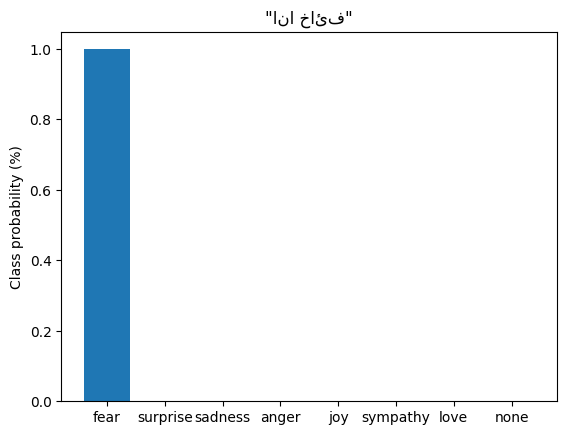

In [65]:
# Predict on custom tweet
custom_tweet = 'انا خائف'
preds_custom = classifier(custom_tweet, top_k=None)


# ['none', 'anger', 'joy', 'sadness', 'love', 'sympathy', 'surprise', 'fear']

# Define the label mapping
label_mapping = {
    'LABEL_0': 'none',
    'LABEL_1': 'anger',
    'LABEL_2': 'joy',
    'LABEL_3': 'sadness',
    'LABEL_4': 'love',
    'LABEL_5': 'sympathy',
    'LABEL_6': 'surprise',
    'LABEL_7': 'fear'
}

# Extract class labels and scores with human-readable labels
labels = [label_mapping[pred['label']] for pred in preds_custom]
scores = [pred['score'] for pred in preds_custom]


# Plotting the class probabilities
plt.bar(labels, scores, color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel('Class probability (%)')
plt.show()

### `Evaluate on Test Dataset`

In [67]:
# Evaluate on test dataset (The dataset which will passed to classifier is just a natural language)
y_pred_test = classifier(emotions['test']['tweet'])

In [68]:
# Slicing only the number of label from the output of the classifier
preds_test = []
for each_pred in y_pred_test:
  preds_test.append(int(each_pred['label'].split('_')[-1]))

In [69]:
# Here is a DF for the test dataset contains the text, ground truth (label), and the predicted label
df_preds_test = pd.DataFrame({'text': emotions['test']['tweet'], 'label': emotions['test']['label'], 'predicted': preds_test})
df_preds_test

,text,label,predicted
0,انت تقول مجوسي لعنه الله علي ايران والمجوس وكل...,1,1
1,انت اول حب واخر حب هعيش وياه... واللي بيني وبي...,2,4
2,mnsour اتكذب ارضاءاً لملوك العهر اتقي الله ف...,1,1
3,رئيس جنوب السودان يعزل وزراء موالين لمشار: عزل...,1,1
4,اقعد 3 ايام و انا بنزل 16 جيجا من النت!!,6,6
...,...,...,...
1001,C100 كابوووس الهلال يلاحق النصراويين حتي في تب...,7,4
1002,: shosho اني عكسكم خايفه 😶,7,7
1003,الدموع رافضه تنزل والقلب حالف مايبطل,3,3
1004,البرازيل نظمت كاس العالم من سنتين و دلوقتي الا...,0,0


In [70]:
# Get the scores on test dataset
acc_test = accuracy_score(df_preds_test['label'], df_preds_test['predicted'])
f1_test = f1_score(df_preds_test['label'], df_preds_test['predicted'], average='weighted')

print(f'The accuracy score on Test Dataset is: {acc_test:.3f}')
print(f'The f1_score on Test Dataset is: {f1_test:.3f}')

The accuracy score on Test Dataset is: 0.677
The f1_score on Test Dataset is: 0.677
